In [464]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from env import api_key
import requests
import json
from acquire import *
from bs4 import BeautifulSoup
import os
import re
from prepare import *
import IPython
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import seaborn as sns


In [451]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler

In [2]:
df = pd.read_csv("master_df.csv")

In [3]:
df = prepare_bills_for_processing(df)

In [4]:
df['lem'] = df.bill_text.apply(clean_text)

In [5]:
df['model'] = df.lem.apply(join)

In [6]:
df.head()

,sponsor,party,bill_text,lem,model
0,"Torres Small, Xochitl",D,\n\n\n \n To require the Secretary of Homelan...,"[require, homeland, security, develop, plan, i...",require homeland security develop plan increas...
1,"Sewell, Terri A.",D,\n\n\n \nTo amend title XI of the Social Secur...,"[amend, xi, social, security, clarify, paramet...",amend xi social security clarify parameter mod...
2,"Finkenauer, Abby",D,\n\n\n \n To repeal the funding authorization ...,"[repeal, funding, sunset, total, funding, cap,...",repeal funding sunset total funding cap americ...
3,"Casten, Sean",D,\n\n\n \nTo direct the Federal Energy Regulato...,"[direct, federal, energy, regulatory, commissi...",direct federal energy regulatory commission fi...
4,"LaMalfa, Doug",R,\n\n\n \n To establish a categorical exclusio...,"[exclusion, electric, utility, rightsof, way, ...",exclusion electric utility rightsof way purpos...


In [7]:
train, X_train, y_train, X_val, y_val, X_test, y_test = split_data(df, 'party')

In [8]:
X_train.head()

,sponsor,bill_text,lem,model
25840,"Frelinghuysen, Rodney P.",\n\n\n \n To suspend temporarily the duty...,"[suspend, temporarily, duty, 3amino12propanedi...",suspend temporarily duty 3amino12propanediol 3...
24423,"Foxx, Virginia",\n\n\n \n Of inquiry requesting the President...,"[inquiry, requesting, president, directing, ed...",inquiry requesting president directing educati...
16270,"Scott, Rick",\n\n\n \n To allow National Flood Insurance Pr...,"[allow, national, flood, insurance, program, p...",allow national flood insurance program policyh...
21136,"Hickenlooper, John W.",\n\n\n \n To provide better access to retireme...,"[provide, better, access, retirement, plan, sm...",provide better access retirement plan small bu...
11697,"Dingell, Debbie",\n\n\n \n To amend the Energy Policy and C...,"[amend, energy, policy, conservation, modify, ...",amend energy policy conservation modify defini...


In [9]:
all_bill_words = clean_text(' '.join(df['bill_text']))

In [10]:
democrat_words = clean_text(' '.join(df[df['party'] == 'D']['bill_text']))

In [11]:
republican_words = clean_text(' '.join(df[df['party'] == 'R']['bill_text']))

In [12]:
all_bill_bigrams = pd.Series(nltk.ngrams(all_bill_words, 2))
all_bill_bigrams

0                (require, homeland)
1               (homeland, security)
2                (security, develop)
3                    (develop, plan)
4                   (plan, increase)
                      ...           
24484553        (entered, withdrawn)
24484554      (withdrawn, warehouse)
24484555    (warehouse, consumption)
24484556         (consumption, 15th)
24484557             (15th, ltallgt)
Length: 24484558, dtype: object

In [13]:
top_bill_bigrams = all_bill_bigrams.value_counts().head(40)

In [14]:
top_bill_bigrams

(public, health)            22857
(health, care)              20538
(public, law)               18478
(state, local)              17875
(higher, education)         17493
(social, security)          17308
(homeland, security)        16395
(meaning, given)            16092
(given, term)               15868
(law, enforcement)          15468
(internal, revenue)         15064
(indian, tribe)             15000
(small, business)           14057
(health, service)           13736
(attorney, general)         13678
(federal, agency)           13592
(revenue, 1986)             13153
(health, human)             11866
(human, service)            11837
(purpose, cited)            11714
(local, government)         11661
(institution, higher)       11206
(mental, health)            10592
(grant, program)            10412
(generalnot, later)         10090
(180, day)                  10009
(pilot, program)             9979
(inspector, general)         9416
(federal, government)        9357
(national, sec

In [459]:
def democrat_bigrams_viz(df):
    more_stopwords = ['secretary','united','states','senate','house','representative',
                   'representatives','fiscal','year','shall','adding','end','paragraph',
                   'made','available','prebody','subsection','day','date','submit','described',
                   'may','congress','following','new','enactment','code','section','assembled',
                   'b','c','amended','short','title','sec','heading', 'et', 'seq',
                    'chapter', 'effective','enacted','subchapter','entity', '42', 'usc', 'act', 'establish',
                       'categorical', 'america', '1', '2', 'seq','authorization',
                       'appropriations', 'appropriated', 'inserting','numerical',
                       'sequence','ii']
    
    democrat_words = clean_text(' '.join(df[df['party'] == 'D']['bill_text']), 
                                 more_stopwords)
    democrat_bigrams = pd.Series(nltk.ngrams(democrat_words, 2))
    top_democrat_bigrams =democrat_bigrams.value_counts().head(40)
    top_democrat_bigrams = pd.DataFrame(top_democrat_bigrams)
    top_democrat_bigrams['party'] = 'D'
    republican_words = clean_text(' '.join(df[df['party'] == 'R']['bill_text']), 
                                  more_stopwords)
    republican_bigrams = pd.Series(nltk.ngrams(republican_words, 2))
    top_republican_bigrams =republican_bigrams.value_counts().head(40)
    top_republican_bigrams = pd.DataFrame(top_republican_bigrams)
    top_republican_bigrams['party'] = 'R'
    top_democrat_bigrams.reset_index(inplace = True)
    top_republican_bigrams.reset_index(inplace = True)
    top_democrat_bigrams.rename(columns={"index": "bigram", 
                                         0: "frequency"},inplace = True)
        
    top_republican_bigrams.rename(columns={"index": "bigram", 
                                       0: "frequency"},inplace = True)
    scaler = StandardScaler()
    top_republican_bigrams['scaled_freq'] = scaler.fit_transform(top_republican_bigrams['frequency'].values.reshape(-1, 1))

    top_democrat_bigrams['scaled_freq'] = scaler.fit_transform(top_democrat_bigrams['frequency'].values.reshape(-1, 1))
    top_bigrams = pd.concat([top_democrat_bigrams.head(10), top_republican_bigrams.head(10)], 
                       ignore_index = True)
    top_bigrams.sort_values(by = ['scaled_freq'], ascending = False ,inplace = True)

    fig = px.bar(top_bigrams, x='scaled_freq', y='party', 
                 template='plotly_white', orientation='h',
                 labels={'scaled_freq': 'Frequency of Bigram', 'bigram': 'Bigram', 
                         'party': 'Party'},
                 color='bigram', color_discrete_sequence=px.colors.qualitative.Safe)
        
    fig.update_layout(font=dict(size=10, color='DarkSlateGray'))
    fig.update_layout(width=800, height=500)
    fig.show()
    
    return top_bigrams.head(2)




In [460]:
democrat_bigrams_viz(df)

,bigram,frequency,party,scaled_freq
10,"(homeland, security)",7261,R,3.859656
0,"(public, health)",18007,D,2.899877


In [21]:
dem_counts = pd.Series(democrat_words).value_counts()

In [22]:
rep_counts = pd.Series(republican_words).value_counts()

In [23]:
all_counts = pd.Series(all_bill_words).value_counts()

In [24]:
word_freq = pd.concat([dem_counts, rep_counts, all_counts], axis = 1)
word_freq.head(40)

,0,1,2
program,141582.0,33156.0,175478
service,124381.0,35043.0,160319
state,120042.0,37763.0,158386
including,109187.0,27716.0,137491
health,105155.0,26996.0,133023
3,103356.0,36016.0,140166
term,101644.0,32560.0,134923
federal,98068.0,35525.0,134275
individual,90170.0,24714.0,115502
grant,78630.0,13902.0,93000


In [25]:
word_freq.columns = ['democrat', 'republican', 'all']
word_freq.fillna(0, inplace=True)
word_freq.head()

,democrat,republican,all
program,141582.0,33156.0,175478
service,124381.0,35043.0,160319
state,120042.0,37763.0,158386
including,109187.0,27716.0,137491
health,105155.0,26996.0,133023


In [592]:

more_stopwords = ['secretary','united','states','senate','house','representative',
                   'representatives','fiscal','year','shall','adding','end','paragraph',
                   'made','available','prebody','subsection','day','date','submit','described',
                   'may','congress','following','new','enactment','code','section','assembled',
                   'b','c','amended','short','title','sec','heading', 'et', 'seq',
                    'chapter', 'effective','enacted','subchapter','entity', '42', 'usc', 'act', 'establish',
                       'categorical', 'america', '1', '2', 'seq','authorization',
                       'appropriations', 'appropriated', 'inserting','numerical',
                       'sequence','ii','meaning','given','term']
    
democrat_words = clean_text(' '.join(df[df['party'] == 'D']['bill_text']),more_stopwords)
republican_words = clean_text(' '.join(df[df['party'] == 'R']['bill_text']),more_stopwords)
    
republican_trigrams = pd.Series(nltk.ngrams(republican_words, 3))
top_republican_trigrams =pd.DataFrame(republican_trigrams.value_counts().head(40))
democrat_trigrams = pd.Series(nltk.ngrams(democrat_words, 3))
top_democrat_trigrams =pd.DataFrame(democrat_trigrams.value_counts().head(40))
top_democrat_trigrams['party'] = 'D'
top_republican_trigrams['party'] = 'R'
top_democrat_trigrams.reset_index(inplace = True)
top_republican_trigrams.reset_index(inplace = True)
top_democrat_trigrams.rename(columns={"index": "trigram", 0: "frequency"},inplace = True)

top_republican_trigrams.rename(columns={"index": "trigram", 0: "frequency"},inplace = True)
                                       
scaler = StandardScaler()
top_republican_trigrams['scaled_freq'] = scaler.fit_transform(top_republican_trigrams['frequency'].values.reshape(-1, 1))

top_democrat_trigrams['scaled_freq'] = scaler.fit_transform(top_democrat_trigrams['frequency'].values.reshape(-1, 1))
top_trigrams = pd.concat([top_democrat_trigrams.head(10), top_republican_trigrams.head(10)], ignore_index=True)
                          
top_trigrams.sort_values(by = ['scaled_freq'], ascending = False ,inplace = True)


    

In [593]:
top_trigrams.sort_values(by = 'scaled_freq', inplace = True, ascending = False)

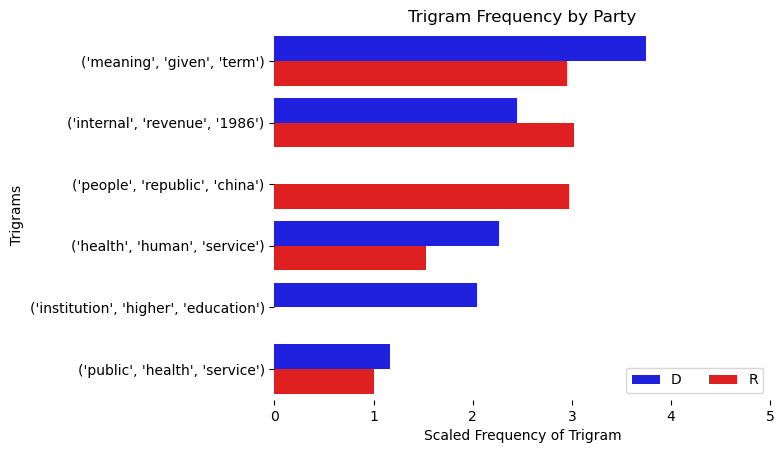

In [594]:
pal = {"R" : "red",
      "D" : "blue"}

ax = sns.barplot(x="scaled_freq", y="trigram", data=top_trigrams.head(10),hue = 'party', 
                 palette = pal)

ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 5), ylabel="Trigrams",
       xlabel="Scaled Frequency of Trigram", title = 'Trigram Frequency by Party')
sns.despine(left=True, bottom=True)


plt.show()

In [520]:
republican_trigram_viz(df)

KeyboardInterrupt: 

In [578]:
more_stopwords = ['secretary','united','states','senate','house','representative',
                   'representatives','fiscal','year','shall','adding','end','paragraph',
                   'made','available','prebody','subsection','day','date','submit','described',
                   'may','congress','following','new','enactment','code','section','assembled',
                   'b','c','amended','short','title','sec','heading', 'et', 'seq',
                    'chapter', 'effective','enacted','subchapter','entity', '42', 'usc', 'act', 'establish',
                       'categorical', 'america', '1', '2', 'seq','authorization',
                       'appropriations', 'appropriated', 'inserting','numerical',
                       'sequence','ii']
    
democrat_words = clean_text(' '.join(df[df['party'] == 'D']['bill_text']), 
                                 more_stopwords)
democrat_bigrams = pd.Series(nltk.ngrams(democrat_words, 2))
top_democrat_bigrams =democrat_bigrams.value_counts().head(40)
top_democrat_bigrams = pd.DataFrame(top_democrat_bigrams)
top_democrat_bigrams['party'] = 'D'
republican_words = clean_text(' '.join(df[df['party'] == 'R']['bill_text']), 
                              more_stopwords)
republican_bigrams = pd.Series(nltk.ngrams(republican_words, 2))
top_republican_bigrams =republican_bigrams.value_counts().head(40)
top_republican_bigrams = pd.DataFrame(top_republican_bigrams)
top_republican_bigrams['party'] = 'R'
top_democrat_bigrams.reset_index(inplace = True)
top_republican_bigrams.reset_index(inplace = True)
top_democrat_bigrams.rename(columns={"index": "bigram", 
                                     0: "frequency"},inplace = True)
        
top_republican_bigrams.rename(columns={"index": "bigram", 
                                    0: "frequency"},inplace = True)
scaler = StandardScaler()
top_republican_bigrams['scaled_freq'] = scaler.fit_transform(top_republican_bigrams['frequency'].values.reshape(-1, 1))

top_democrat_bigrams['scaled_freq'] = scaler.fit_transform(top_democrat_bigrams['frequency'].values.reshape(-1, 1))
top_bigrams = pd.concat([top_democrat_bigrams.head(10), top_republican_bigrams.head(10)], 
                        ignore_index = True)
top_bigrams.sort_values(by = ['scaled_freq'], ascending = False ,inplace = True)

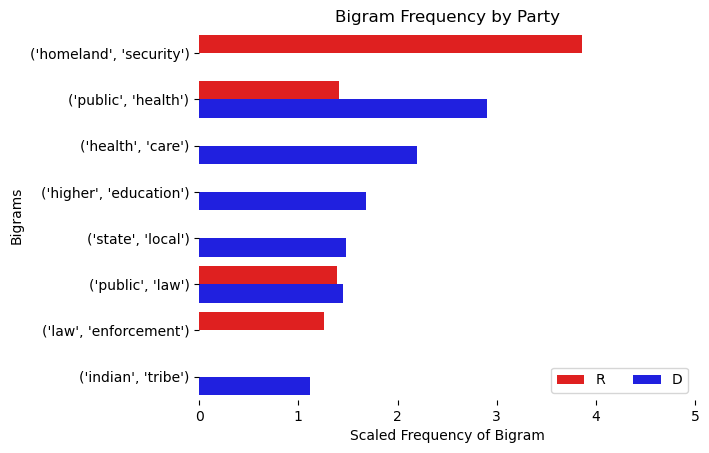

In [587]:
pal = {"R" : "red",
      "D" : "blue"}

ax = sns.barplot(x="scaled_freq", y="bigram", data=top_bigrams.head(10),hue = 'party', 
                 palette = pal)

ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 5), ylabel="Bigrams",
       xlabel="Scaled Frequency of Bigram", title = 'Bigram Frequency by Party')
sns.despine(left=True, bottom=True)


plt.show()